When it comes to consuming real-time content, Twitter is the place to be; Be it sending out 'Tweets' real-time, or discovering latest online 'Trends' anywhere, or ability to begin a 'conversation' with anyone, Twitter does it all. In fact, Twitter Management wrote this in their [letter to shareholders][1] last year. 
[1]: http://files.shareholder.com/downloads/AMDA-2F526X/106725176x0x874459/8A4D1A1D-D184-4AFE-9AC1-F880C5EA06F1/Q415_Shareholder_Letter.pdf

> _We’re focused now on what Twitter does best: live. Twitter is live: live commentary, live connections, live conversations. Whether it’s breaking news, entertainment, sports, or everyday topics, hearing about and watching a live event unfold is the fastest way to understand the power of Twitter._ 

> _Twitter has always been considered a “second screen” for what’s happening in the world and we believe we can become the first screen for everything that’s happening now. And by doing so, we believe we can build the planet’s largest daily connected audience. A connected audience is one that watches together, and can talk with one another in real-time. It’s what Twitter has provided for close to 10 years, and it’s what we will continue to drive in the future_

Embedded in a Twitter User's Social-graph* is a wealth of information on User's likes and interests. Unlike Facebook or LinkedIn, the magic of Twitter is in its 'Follow' structure - where any can follow any without they knowing each other. This directed social-graph, when methodologically summarized, can reveal interesting information on the most influential/central friends in the network and also help personalize/enrich one's Twitter experience by unearthing implicit-clusters in the network.

_*Social-graph: [User, 1st degree Connections, and the links between]_

In this notebook, we'll look into these: 
1. Extract the ego-network of 'self' using Twitter API 
+ Identify the influential nodes using 'Page Rank' formulation 
+ Identify implicit clusters formed
+ Recommend new friends to follow on the basis of cluster of interest 

Note: This study is limited to  Ego network: the focal node ("ego": here the self-node) and the nodes to whom ego is directly connected to ("alters") plus the ties, if any, among the alters. 

## 1. Extract social-graph strucutre using Twitter API 

In [1]:
from collections import Counter, defaultdict
from datetime import datetime
from sklearn.decomposition import PCA

import csv
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns;  sns.set()
import time
import twitter

% matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

import warnings
warnings.filterwarnings("ignore")
#print twitter.__path__  

import random
random.seed(1000)

In [2]:
# Pandas data-frame print formatting
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
self_screen_name = 'bala_io'            # Self

# Keep appending data
fof_filename     = "edges.csv"          # 'Alters' and their Source->Sink Edges. 
cache_filename   = "cache.csv"          # local cache of (TwitterId, FullName, UserName)

# One-time-use files
binaryMap_filename = "binaryMap.csv"   # Directed Graph. Adjacencies as 0/1.RowFollowCol
cluster_filename   = "results.csv"

In [4]:
# Twitter auth. https://dev.twitter.com/oauth/overview/application-owner-access-tokens

with open("../../passwd/credentials.txt", "r") as f:
    reader = csv.reader(f )
    login_dict = {line[0]: line[1]                       
                    for line in reader}        

api = twitter.Api(consumer_key=login_dict.get('consumer_key') ,
                  consumer_secret=login_dict.get('consumer_secret'),
                  access_token_key=login_dict.get('access_token_key'),
                  access_token_secret=login_dict.get('access_token_secret'))
api

In [5]:
# 'Self' and Friends of Self

self_node    =  api.GetUser(screen_name = self_screen_name)    
self_node_id =  str(self_node.id)                      # Twitter Id of Self

friends_of_self = api.GetFriendIDs(user_id = self_node_id, 
                                   screen_name = self_screen_name , 
                                   stringify_ids = True)
index = [self_node_id] + friends_of_self

In [6]:
# GetFriendIDs() API call is rate-limited at 15 req / 15 min 
# https://dev.twitter.com/rest/public/rate-limiting

# For each of the list of nodes, fetch the list of nodes it follows, append to file

def update_FoF_File(fileName, to_fetch_list):
    
    with open(fileName, 'a') as f:
        apiReqCount = 0
        
        for node in to_fetch_list:
            friends_of_node = api.GetFriendIDs(user_id = node,  stringify_ids = True) 
            row = ','.join([str(i) for i in [node] +  friends_of_node ]) + "\n"
            f.write(row) 
            
            apiReqCount += 1
            
            if (apiReqCount == 15): 
                apiReqCount = 0
                
                print("Off to Sleep :)")
                time.sleep(15*60 + 10)  

In [7]:
# parse FoF file and return list of nodes, for whom source->sink Edges are already there.

def getFinishList(fileName):
        
    if not os.path.isfile(fileName):
        return [] 
    with open(fileName, 'r') as f:
        return [ row.strip().split(',')[0] for row in f ]  # 1st entry is a user

In [8]:
# Ego-network as adjacency-matrix
# Parses FoF file in order of index, create list of adjacencies as 0 | 1
# Writes to File. Adjacency-matrix in Row_follows_Column format

def updateBinaryMapFile(fof_filename, binaryMap_filename, index):
    
    with open(fof_filename, "r") as f:
        stripped_f = (line.replace('\r', '') for line in f)
        reader = csv.reader(stripped_f)
        fof_dict = {line[0]: line[1:] for line in reader 
                    if line[0] in index}   # dict of node:his_followers
        if self_node_id not in fof_dict:
            fof_dict[self_node_id] = index[1:]             # dict of Self
    
    bool_list = []
    
    for user in index:
        user_friends = set( fof_dict[user] )  
        bool_row = [item in user_friends for item in index]  # for each, fill T/F 
        bool_list.append(bool_row)
    
    int_nparray = np.array(bool_list) + 0                    # Bool to int

    binaryMap_rfc = pd.DataFrame(data = int_nparray, columns= index, index = index)
    binaryMap_rfc.to_csv(binaryMap_filename)

In [9]:
# For list of Ids, fetch Profile details. If not in Offline file, make an API call
# Returns ['UserName', 'FullName', 'Followers_count', 'Friends_count', 'Location', 'Created_at']
# UsersLookup API 100 Ids/request

def lookup_in_cache(friendsIdsList):

    cache, delta_cache = pd.DataFrame(), pd.DataFrame()
    UserNameList, namesList     = [], []
    followers_count, friends_count = [], []
    location, created_at           = [], []
    
    if os.path.isfile(cache_filename):
        cache = pd.read_csv(cache_filename, skip_blank_lines=True,
                        dtype={'Ids':str, 'Friends_count':int, 'Followers_count':int})
        cache.set_index('Ids', inplace=True)
        to_fetch_list = list ( set (friendsIdsList) - set(cache.index) )
    else :        
        to_fetch_list = friendsIdsList   
    
    i = 0
    while (i < len(to_fetch_list) * 1./100):   
        print("... Cache-Miss for " + str(len(to_fetch_list)) +  " nodes. Updating Cache...")
        low, high = i * 100, min( len(to_fetch_list), (i+1)*100 )  # UsersLookup api
        twitterObjectsList = api.UsersLookup(user_id = to_fetch_list[low:high])    
        
        temp = zip(*[( tempObject.screen_name,        #ScreenName
                      tempObject.name,                #Name
                      tempObject.followers_count,     #Followers
                      tempObject.friends_count,       #Friends
                      tempObject.location,            #Location
                      tempObject.created_at           #CreatedAt
                     ) for tempObject in twitterObjectsList])
        temp = list(temp)
        
        UserNameList    += list(temp[0])
        namesList       += list(temp[1])
        followers_count += list(temp[2])
        friends_count   += list(temp[3])
        location        += list(temp[4])
        created_at      += list(temp[5])
        
        i = i + 1       
    
    if len(to_fetch_list) > 0:
        delta_cache  = pd.DataFrame({'UserName':UserNameList,
                                     'FullName':namesList,
                                     'Ids': to_fetch_list,
                                     'Followers':followers_count,
                                     'Friends': friends_count,
                                     'Location':location,
                                     'Created':created_at})
        
        delta_cache['Created'] = delta_cache['Created'].apply(lambda x: 
                                                datetime.strptime(
                                                    re.sub(r"\+[0-9]* ", "",x),'%c').
                                                strftime("%b-%Y"))
    
        delta_cache.set_index('Ids', inplace=True, drop = True)
        cache = cache.append(delta_cache)
        cache.to_csv(cache_filename)        

    return cache.loc[friendsIdsList]

In [10]:
# Display cluster-wise most-influential users, for the given clustering algo

def top_nodes_in_cluster(df, cluster_algo, n_clusters):
    dummy_df = pd.DataFrame()

    for i in range(n_clusters):
        nodes_in_cluster = list( df [df[cluster_algo] == i ]['FullName'] )     
        if len(nodes_in_cluster) >= 10:            # show only clusters of size > 10        
            col_name           = str(i) + " : " + str(len(nodes_in_cluster)) + " Ids"
            dummy_df[col_name] = nodes_in_cluster[:10]      
    
    return dummy_df   

In [11]:
# identify 20 friends to follow after aggregating friends followed by top 50% in list

def discover_Friends_toFollow(ids_of_interest, friend_list, prop = .5, count = 20):    
    
    ids_of_interest  = ids_of_interest[:int(len(ids_of_interest) * prop)]
    
    if self_node_id in ids_of_interest:
        ids_of_interest.remove(self_node_id)

    print("'Who-To-Follow' reco after looking at %3d friends' friends:" %(len(ids_of_interest)))
    
    with open(fof_filename) as f:
        reader = csv.reader(f)
        fof_dict = {row[0]:row[0:] for row in reader}  # dict of node:her_followers

    friendsToFollow = []
    for id in ids_of_interest:
        friendsToFollow += list (set(fof_dict[str(id)])  - set(friend_list) ) 
        

    friendsToFollow = Counter(friendsToFollow).most_common(count)    
    tuples_list = list(zip(*friendsToFollow) )
           
    topFriendsToFollowDF = pd.DataFrame()
    topFriendsToFollowDF['Ids'] = list(tuples_list[0])
    topFriendsToFollowDF['Freq'] = list(tuples_list[1])
    topFriendsToFollowDF.set_index('Ids', drop = True, inplace = True)              
    index = topFriendsToFollowDF.index
    
    topFriendsToFollowDF = topFriendsToFollowDF.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)
    
    return topFriendsToFollowDF    

In [12]:
# For the list of nodes I follow, fetch their friends-list

fof_finish_list   = getFinishList(fof_filename )        # Completed nodes
fof_to_fetch_list = list ( set(friends_of_self) - set(fof_finish_list) )  # Pending nodes

print( str(len(fof_to_fetch_list)) + " out of " + str(len(index)  - 1) + 
      " Friends details to be fetched")

1 out of 376 Friends details to be fetched


In [13]:
# For the remaining nodes, populate their details in fof_file
update_FoF_File(fof_filename, fof_to_fetch_list) 

# Build the adjacency matrix in terms of 0 and 1 (if there is an edge)
updateBinaryMapFile(fof_filename, binaryMap_filename, index)

In [14]:
# Read adj-matrix into df. Cell MxN is 1 iff node in Mth row follows node in Nth column 
binaryMap_rfc = pd.read_csv(binaryMap_filename, skip_blank_lines=True, index_col = 0)
print(binaryMap_rfc.shape)


outlinks_count = binaryMap_rfc.sum(axis = 1)   # horizontal-sum to count outlinks
inlinks_count = binaryMap_rfc.sum(axis = 0)   # vertical-sum to count inlinks

(377, 377)


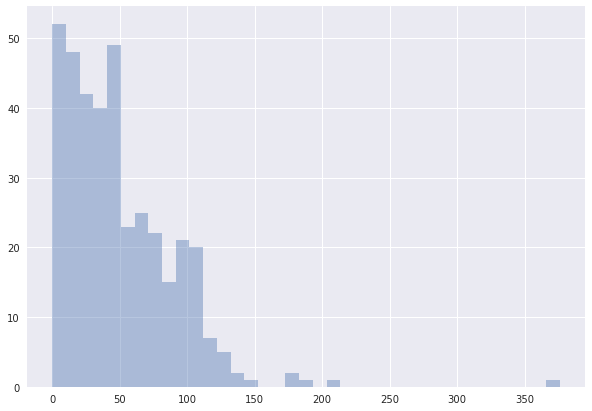

In [15]:
# Histogram of number of OutLinks per node, within ego-network
sns.distplot(outlinks_count, bins = len(index)//10, kde=False);

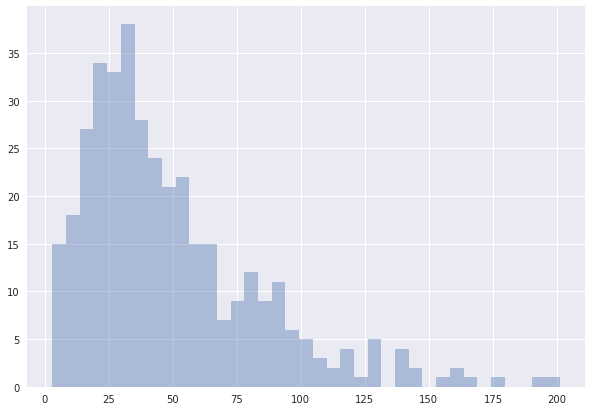

In [16]:
# Histogram of number of InLinks per node, within ego-network
sns.distplot(inlinks_count, bins = len(index)//10, kde=False);

## 2. Identify influential friends using 'Page Rank' formulation

From the adjacency matrix generated above, we can construct a column-stochastic matrix  (also called a transition matrix) such that, a column with `m` outlinks will have `1/m` as value in respective `m` cells. Conceptually, a value in the cell `a x b` gives the probability of a random-surfer in node B jumping to node A. 

In [17]:
binaryMap_cfr      = binaryMap_rfc.transpose()            # column-values: Outlinks
binaryMap_cfr_norm = binaryMap_cfr / binaryMap_cfr.sum(axis = 0)
colStochMatrix = np.matrix( binaryMap_cfr_norm.fillna(0)) # column-stochastic-matrix

_Initialize PageRank vector, such that all the nodes have equal PageRank score adding upto 1._

In [18]:
pageRankVector = np.matrix([1.0/len(index)] *  len(index)) # iniitialize page-rank-vector 
pageRankVector = pageRankVector.transpose()                # transpose to column-vector

On applying the above Transition-matrix transformation iteratively on the PageRank vector, the vector will eventully converge such that:

`Matrix.Vector = Vector`

Equivalently, this is Eigen-Vector formulation with PageRank vector being the principal eigen-vector of matrix corresponding to eigen-value `1` [Since M is column-stochastic matrix, principal eigen-value is 1]

Here we use Power Iteration method to solve for the PageRank vector. Inorder to handle  the nodes which have zero out-links (dead-ends) and nodes with periodic-loops (spider-traps) in the ego-network, we introduce some randomness through parameter `beta` such that a random-surfer at any node picks a random path approx. every 1 out of 6 times ( 1 - beta = 0.15)

In [19]:
# PageRank algo: Power Iteration to solve Markov transition matrix 
# refer this     : http://setosa.io/blog/2014/07/26/markov-chains/index.html

beta = 0.85
epsilon = 999
iteration = 0
while epsilon > (1.0/(10**16)):
    pageRankVectorUpdating = colStochMatrix * pageRankVector * beta 
    
    # re-insert leaked page-ranks
    S = np.array(pageRankVectorUpdating).sum()                      
    pageRankVectorUpdated = pageRankVectorUpdating + (
        1 - S) * (1.0/len(index)) * np.ones_like(len(index))
    
    # compute the squared-difference and check for convergence
    error = np.array(pageRankVectorUpdated - pageRankVector)
    epsilon = np.sqrt((error *  error).sum())   
    iteration = iteration + 1
    pageRankVector = pageRankVectorUpdated    
    
print( "Sum of Page-Rank Scores: " + str(pageRankVector.sum()) + 
      "\nConverged in " + str(iteration) + " iterations")

Sum of Page-Rank Scores: 1.0
Converged in 58 iterations


In [20]:
# Collect the results

results_df = pd.DataFrame()
results_df['Ids'], results_df['PageRank'] = index, pageRankVector
results_df['Inlinks'], results_df['Outlinks'] = list(inlinks_count), list(outlinks_count)
results_df = results_df.set_index('Ids', drop = True )

results_df = results_df.merge(lookup_in_cache(index), copy = False,
                              left_index = True, right_index = True)
results_df = results_df[['PageRank','UserName', 'FullName', 'Inlinks' , 'Outlinks',
                         'Followers','Friends', 'Location', 'Created' ]] 

... Cache-Miss for 1 nodes. Updating Cache...


#### 2a. Nodes with high PageRank scores

In [21]:
results_df.fillna('').sort_values(by = 'PageRank', ascending =False).set_index('FullName').head(10)

,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created
FullName,,,,,,,,
Elon Musk,0.014158,elonmusk,201,4,8845530,41,Boring,Jun-2009
Bill Gates,0.011921,BillGates,168,16,34940895,183,"Seattle, WA",Jun-2009
Marc Andreessen,0.011725,pmarca,192,24,645085,13952,"Menlo Park, CA",May-2007
Edward Snowden,0.010114,Snowden,97,0,3150406,1,,Dec-2014
Tim O'Reilly,0.009973,timoreilly,178,132,1987340,1709,"Oakland, CA",Mar-2007
WIRED,0.009110,WIRED,103,10,8974304,279,San Francisco/New York,Mar-2007
Nate Silver,0.008281,NateSilver538,145,26,2276360,992,New York,Aug-2008
Chris Dixon,0.008217,cdixon,162,184,545467,3054,CA & NYC,Mar-2007
Fred Wilson,0.008190,fredwilson,158,75,617149,1160,New York City,Mar-2007


#### 2b. Top 100 influential-nodes in Ego-Network

In [22]:
dummy_df = pd.DataFrame()
temp_df  = results_df.sort_values( by = 'PageRank', ascending =False)

for i in range(10):
    dummy_df[i] = list (temp_df [10*i : 10* i + 10]['FullName'])
dummy_df

,0,1,2,3,4,5,6,7,8,9
0,Elon Musk,Reid Hoffman,Sam Altman,Tim Urban,Microsoft Research,Brian Chesky,Tony Fadell,John D. Cook,David Sacks,Clayton Christensen
1,Bill Gates,Bill Gurley,Steven Levy,Joi Ito,John Markoff,Max Roser,Matt Cutts,Naval Ravikant,Tim Berners-Lee,GV
2,Marc Andreessen,Eric Schmidt,Chris Anderson,Benedict Evans,Neil deGrasse Tyson,Bradley Horowitz,Yann LeCun,Tim Ferriss,Recode,Mark Suster
3,Edward Snowden,Paul Graham,Hilary Mason,Brad Stone,Charlie Rose Show,🍪Steven Sinofsky ॐ,Atul Gawande,John Lilly,Sarah Lacy,Drew Conway
4,Tim O'Reilly,Vinod Khosla,OpenAI,NassimNicholasTaleb,Bill Gross,Gabe Rivera,Jessica Lessin,Dan Primack,Edward Tufte,Fei-Fei Li
5,WIRED,Om Malik,Steve Case,Josh Kopelman,danah boyd,Walt Mossberg,Google Research,Jimmy Wales,Sebastian Thrun,Mike Bloomberg
6,Nate Silver,TechCrunch,Sundar Pichai,DAVE MORIN,Pierre Omidyar,Steven Pinker,Jonah Peretti,Paul Kedrosky,Josh Elman,a16z
7,Chris Dixon,Ben Horowitz,Patrick Collison,Hunter Walk,Emily Chang,Keith Rabois,jason,Startup L. Jackson,Jeff Hammerbacher,Kevin Weil
8,Fred Wilson,Kara Swisher,Max Levchin,Y Combinator,dj patil,Andrew Ng,EFF,Kevin Kelly,Bret Taylor,Mike Bostock
9,Ev Williams,Chris Sacca,Nick Bilton,Lessig,Ben Thompson,Glenn Greenwald,Chamath Palihapitiya,John Collison,Paul Buchheit,Jeff Jordan


#### 2c. Histogram of PageRank scores

PageRank scores are scaled such that nodes have an average-score of 1. So the scores below give an idea of how influential are the nodes, with respect to an average node. 

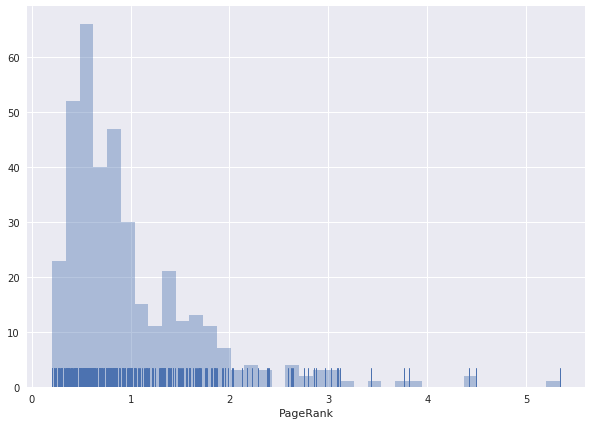

In [23]:
pageRank_to_plot = len(index) * results_df["PageRank"]
sns.distplot(pageRank_to_plot, kde=False, rug=True, bins = len(index)//10);

A joint-plot showing how Inlinks and Outlinks of the nodes are distributed (within the ego-network)

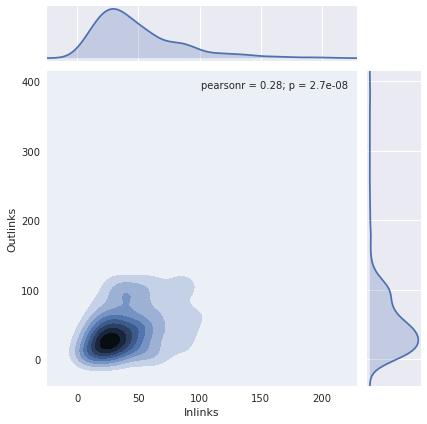

In [24]:
sns.jointplot(x="Inlinks", y="Outlinks", data=results_df, kind = "kde");

## 3. Identify implicit clusters using Clustering algos

Typically, number of clusters are chosen with a plot of within-cluster sum-of-squares-of-dstances vs number of clusters. 
Here for simplicity, we use a simple heuristic to fix the number of clusters in advnace.

In [25]:
n_clusters = min( int( round(np.sqrt(len(index)/2)) ), 10 ) # not more than 10 clusters
print(n_clusters)

10


## 3a. K-Means clustering

K Means is a point-assignment based clustering-algorithm: here we start with k points chosen randomly as centroids,  assign the remaining points to k centroids by using certain distance measure (Euclidean / Cosine / Jaccardi). Then we compute new centroids, re-assign remaining points and repeat, until there is convergence of centroids. 

Here we are more interested in clustering inherent in who-follows-me (network-driven) graph, rather than who-do-I-follow (self-driven). So the approach is to represent the nodes as Observations and whether other nodes follow them or not (1 or 0) as Features (One observation per row, and one feature per column) Thus the input matrix must be such that any value in cell implies whether node in the column follows node in the row.

In [26]:
from sklearn.cluster import KMeans
est = KMeans(max_iter = 100000, n_clusters = n_clusters, n_init = 200, init='k-means++')  
results_df['kmeans'] = est.fit_predict(binaryMap_cfr)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'kmeans', n_clusters)

,0 : 45 Ids,1 : 67 Ids,2 : 39 Ids,3 : 28 Ids,4 : 21 Ids,5 : 17 Ids,6 : 15 Ids,7 : 24 Ids,8 : 18 Ids,9 : 103 Ids
0,Edward Snowden,Tim Urban,John D. Cook,Hilary Mason,OpenAI,Elon Musk,WIRED,Mike Bostock,NassimNicholasTaleb,Charlie Rose Show
1,Nate Silver,Tim Ferriss,Lynn Cherny,dj patil,Microsoft Research,Bill Gates,Eric Schmidt,Gilad Lotan,Neil deGrasse Tyson,Irene Au
2,Sundar Pichai,GV,Ben Hamner,Jeff Hammerbacher,Andrew Ng,Marc Andreessen,TechCrunch,Jeffrey Heer,Max Roser,Steven Brooks
3,Patrick Collison,Mike Bloomberg,David Smith,Drew Conway,Yann LeCun,Tim O'Reilly,Steven Levy,Martin Wattenberg,Steven Pinker,Udacity
4,Nick Bilton,Garry Tan,Fernando Perez,Wes McKinney,Google Research,Chris Dixon,Chris Anderson,Andrew Gelman,Glenn Greenwald,briankrebs
5,Benedict Evans,Joe Gebbia,Andreas Mueller,Monica Rogati,Sebastian Thrun,Fred Wilson,Steve Case,Fernanda Viégas,Atul Gawande,Christopher Soghoian
6,Brad Stone,Yves Behar,Kaggle,Hadley Wickham,Fei-Fei Li,Ev Williams,Joi Ito,Steven Strogatz,EFF,IDEO
7,Josh Kopelman,Ashlee Vance,John Foreman,Sean J. Taylor,Andrej Karpathy,Reid Hoffman,Lessig,Duncan Watts,Kevin Kelly,Stanford University
8,DAVE MORIN,Dustin Moskovitz,Jake VanderPlas,Nathan Yau,Shivon Zilis,Bill Gurley,John Markoff,Kenneth Cukier,Tim Berners-Lee,Gary Marcus
9,Hunter Walk,Balaji S. Srinivasan,Scientific Python,Peter Skomoroch,Pedro Domingos,Paul Graham,Bill Gross,Sinan Aral,Edward Tufte,Matías Duarte


## 3b. Spectral clustering

One problem in using K-Means algorithm to cluster the given social-graph is 'Curse of Dimensionality' i.e. at higher-dimensions (here ~400 dimensions), metric like 'Euclidean distance' or 'Centre' would have little meaning in the context of non-convex adjacency matrix.

On the other hand, spectral clustering attempts to partition the graph such that number of edges which connect different components are minimized. Below is the output from Spectral Clustering.

In [27]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=n_clusters,  n_init = 500,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral.fit(binaryMap_cfr)
results_df['spectral'] = spectral.labels_.astype(np.int)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'spectral', n_clusters)

,0 : 34 Ids,2 : 19 Ids,3 : 27 Ids,4 : 55 Ids,5 : 11 Ids,6 : 10 Ids,7 : 187 Ids,8 : 14 Ids,9 : 13 Ids
0,dj patil,Lynn Cherny,Tim O'Reilly,Nate Silver,Hilary Mason,Elon Musk,Edward Snowden,Andrew Ng,Luke Wroblewski
1,Jeff Hammerbacher,Ben Hamner,Ev Williams,Sundar Pichai,Drew Conway,Bill Gates,WIRED,Yann LeCun,Matías Duarte
2,Monica Rogati,Olivier Grisel,Bill Gurley,Patrick Collison,Wes McKinney,Marc Andreessen,Eric Schmidt,Fei-Fei Li,Julie Zhuo
3,Peter Skomoroch,Fernando Perez,Om Malik,Benedict Evans,Hadley Wickham,Chris Dixon,Vinod Khosla,Andrej Karpathy,Jon Wiley
4,Michael E. Driscoll,Andreas Mueller,Kara Swisher,Y Combinator,Sean J. Taylor,Fred Wilson,TechCrunch,Stanford NLP Group,Daniel Burka
5,bradford cross,Jake VanderPlas,Chris Sacca,Emily Chang,Nathan Yau,Reid Hoffman,Chris Anderson,John Platt,Braden Kowitz
6,Jeremy Howard,Scientific Python,Steven Levy,Ben Thompson,John Myles White,Paul Graham,OpenAI,Richard,Google Design
7,Mike Olson,Sebastian Raschka,Nick Bilton,Brian Chesky,chris wiggins,Ben Horowitz,Steve Case,Oren Etzioni,Josh Brewer
8,Anthony Goldbloom,Trey Causey,Josh Kopelman,🍪Steven Sinofsky ॐ,Ben Lorica 罗瑞卡,Sam Altman,Tim Urban,Ian Goodfellow,Jake Knapp
9,Joe Hellerstein,Joshua Bloom,DAVE MORIN,Tony Fadell,Josh Wills,Max Levchin,Joi Ito,Nando de Freitas,John Zeratsky


Nodes mainly into Deep Learning community have grouped into Cluster 8, Python Machine Learning community into Cluster 2, Design community into Cluster 9, general Data Science community into Cluster 0 and 5

One smaller clusters (1) wasn't shown above.

In [29]:
results_df [results_df['spectral'].isin([1])].sort_values(by = 'PageRank', ascending =False).set_index('FullName').head()

,PageRank,UserName,Inlinks,Outlinks,Followers,Friends,Location,Created,kmeans,spectral
FullName,,,,,,,,,,
JAMA,0.000658,JAMA_current,4,3,205154,559,"Chicago, IL",May-2009,9,1
FSI Stanford,0.000643,FSIStanford,5,5,6614,285,"Stanford, CA",Dec-2010,9,1
Adam Johnson,0.000638,AJInsight,4,26,27945,1232,New York,Jul-2010,9,1
PNAS,0.000595,PNASNews,4,17,66720,1110,"Washington, DC",Feb-2011,9,1
IQSS @ Harvard,0.000558,IQSS,5,4,4241,360,"Cambridge, MA",May-2009,9,1


## 3c. Affinity Propagation clustering

Unlike K-Means or Spectral clustering, affinity propagation doesn't require the number of clusters to be estimated beforehand. Here the algorithm finds 'exemplars' i.e. members of dataset that are representative of clusters. and tries to find clusters around them.  

In [30]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50).fit(binaryMap_cfr)
results_df['affinity'] = af.labels_
n_clusters_affinity = len(af.cluster_centers_indices_)

print(str(n_clusters_affinity) + " affinity clusters.")

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'affinity', n_clusters_affinity)

128 affinity clusters.


,2 : 87 Ids,6 : 34 Ids,32 : 23 Ids,38 : 11 Ids,41 : 11 Ids,111 : 42 Ids
0,Tim Urban,Adam Grant,Lynn Cherny,John D. Cook,Jeff Jordan,Yves Behar
1,Charlie Rose Show,Steven Strogatz,Ben Hamner,chris wiggins,Dustin Moskovitz,Ashlee Vance
2,Irene Au,Tim Harford,Olivier Grisel,Jeremy Howard,Balaji S. Srinivasan,WikiLeaks
3,John Carmack,Gary Marcus,Fernando Perez,Xavier Amatriain,Horace Dediu,Seth Godin
4,The Information,DHH,Andreas Mueller,Anthony Goldbloom,Jessica Livingston,Tom Hulme
5,Paul Ford,BJ Fogg,Jake VanderPlas,Kaggle,David Marcus,Udacity
6,briankrebs,Joe Blitzstein,Scientific Python,John Foreman,Frank Chen,IDEO
7,Christopher Soghoian,Brian Nosek,Sebastian Raschka,Edwin Chen,Kleiner Perkins,Scott Dadich
8,John Hagel,Martin Varsavsky,Trey Causey,Mark Faridani,Amir Efrati,ReadWrite
9,Sarah Frier,Russell Roberts,Joshua Bloom,Shane Conway,Scott Kupor,Peter Diamandis


## 3d. Principal Component Analysis

To handle the 'curse of dimensionality' problem inherent in high-dimension data, PCA is generally used to represent the high-dimensional data in a fewer number of dimensions - this helps in better visualizing of data as well as faster computation while running clustering algorithm.

In [31]:
pca = PCA(n_components=3)
Xproj = pca.fit_transform(binaryMap_cfr)

results_df['dim1'] = Xproj[:,0]
results_df['dim2'] = Xproj[:,1]
results_df['dim3'] = Xproj[:,2]

results_df = results_df.sort_values( by = 'PageRank', ascending =False)
results_df.to_csv(cluster_filename)

print("Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]")
print(pca.explained_variance_, pca.explained_variance_ratio_)

Explained-variance and Proportion of Explained-variance in 3 dimensions [dim1 dim2 dim3]
[ 7.09266174  3.16212677  1.21891396] [ 0.18363161  0.08186862  0.03155813]


A simpler visualization of Spectral-clustering outcome as rendered in 2 dimensions.

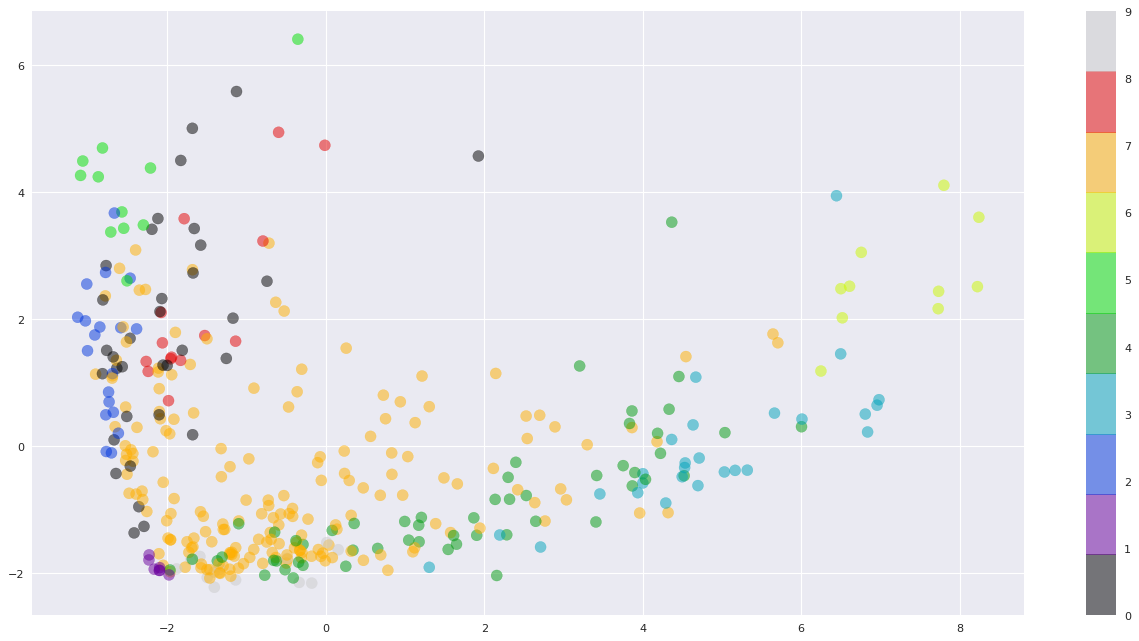

In [32]:
# Spectral clustering | Plot the ego-network in 2 dimensions

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results_df['dim1'], results_df['dim2'], s = 100  ,c= results_df['spectral'], 
            alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

More on Clustering Algorithms:  http://scikit-learn.org/stable/modules/clustering.html

## 4. Recommend new friends to follow

Now that we have PageRank in place for nodes in social-graph, we can ask for recommendations on the basis of top-ranked nodes in the graph. E.g. To get 20 recommendations, after looking at friends of top PageRank scoring nodes in my network

#### 4a. Reco: After looking at top nodes in full ego-network

In [33]:
discover_Friends_toFollow(ids_of_interest = index,
                          friend_list = index, 
                          prop = .5 , count =  20).fillna('').set_index('FullName')

'Who-To-Follow' reco after looking at 187 friends' friends:


,Freq,Created,Followers,Friends,Location,UserName
FullName,,,,,,
Medium,67,May-2012,2188119,78,"San Francisco, CA, US",Medium
Barack Obama,67,Mar-2007,88892730,629775,"Washington, DC",BarackObama
Aaron Levie,52,Mar-2007,1626688,423,Palo Alto,levie
Clay Shirky,51,May-2007,365919,749,Shanghai,cshirky
Mitch Kapor,47,Mar-2007,116400,553,Oakland,mkapor
The New York Times,45,Mar-2007,37377094,894,New York City,nytimes
jack,45,Mar-2006,4055017,2791,"California, USA",jack
marissamayer,44,Nov-2008,1705305,350,"San Francisco, CA",marissamayer
Stewart Butterfield,43,Sep-2006,65193,2418,West coast,stewart


Recommendations on the basis of a specific cluster outcome. 
E.g. Nodes to follow on the basis of top PageRank nodes in 'Spectral Clustering::Data' clusters. 

#### Reco: 4b. After looking at Data-Science clustsers (Spectral clustering)

In [34]:
favorite_cluster_df = results_df [results_df['spectral'].isin([0,2,5,8])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = index, 
                          prop = .5, count = 30).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at  39 friends' friends:
... Cache-Miss for 3 nodes. Updating Cache...


,Freq,Created,Followers,Friends,Location,UserName
FullName,,,,,,
Pete Warden,21,May-2008,12142,1559,"San Francisco, CA",petewarden
Hanna Wallach,19,Sep-2012,7537,795,"Brooklyn, NY",hannawallach
Barack Obama,19,Mar-2007,88892730,629775,"Washington, DC",BarackObama
Alex Smola,19,Jun-2008,8768,48,Mountain View and Pittsburgh,smolix
Hal Daumé III,18,Jun-2010,8702,1017,Washington DC,haldaume3
Chris Diehl,17,Apr-2008,4302,999,"San Francisco Bay Area, CA",ChrisDiehl
Julie Steele,17,Mar-2008,4199,913,NYC and Providence,jsteeleeditor
Joseph Adler,17,Apr-2008,1583,623,Silicon Valley,jadler
joseph reisinger,17,Jul-2009,1933,686,現在地,josephreisinger


#### 4c.Reco:  After looking at Design clustser (Spectral clustering)

In [35]:
discover_Friends_toFollow(ids_of_interest = list(results_df [results_df['spectral'] == 9].index), 
                          friend_list = index, 
                          prop = 1, count = 20).fillna('').set_index('FullName')  

'Who-To-Follow' reco after looking at  13 friends' friends:
... Cache-Miss for 18 nodes. Updating Cache...


,Freq,Created,Followers,Friends,Location,UserName
FullName,,,,,,
Nicholas Jitkoff,8,Jan-2007,4605,204,"Palo Alto, CA",alcor
John Maeda,8,Jul-2008,439273,21724,WordPressLandia,johnmaeda
Joshua Porter,7,Mar-2007,33903,817,"Newburyport, MA",bokardo
Khoi Vinh,7,Dec-2006,347073,2347,"New York, NY",khoi
Brett Lider,7,Dec-2008,6953,947,"San Francisco, California",bl
Margaret Stewart,7,Mar-2007,12846,862,"Bay Area, CA",mags
Paul Stamatiou 📷,7,Jan-2007,33711,599,"San Francisco, CA",Stammy
GV Design,7,Aug-2011,17799,515,"San Francisco, CA",GVDesignTeam
Marc Hemeon,6,Jan-2009,16957,3322,Southern California,hemeon
